# Housing Price Prediction

A US based housing company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

The company wants to know:
1. Which variables are significant in predicting the price of a house, and
2. How well those variables describe the price of a house.

Also, determine the optimal value of lambda for ridge and lasso regression.

 1. Data Understanding and Exploration

In [665]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import RFE

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [666]:
# reading the dataset
housing_raw = pd.read_csv("train.csv")

In [667]:
housing_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [668]:
housing_raw.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [669]:
#Lets check for the fraction of the missing values in each of the columns
null_cols = housing_raw.isnull().mean().sort_values(ascending=False)
null_cols.value_counts()

0.000000    62
0.055479     5
0.025342     3
0.026027     2
0.995205     1
0.963014     1
0.937671     1
0.807534     1
0.597260     1
0.472603     1
0.177397     1
0.005479     1
0.000685     1
Name: count, dtype: int64

In [670]:
# First check the columns to be dropped which are having more than 40% has missing values
cols_to_drop = null_cols[null_cols > 0.40].index
cols_to_drop

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu'], dtype='object')

In [671]:
# Iterate over the columns and print value counts
for col in cols_to_drop:
    print(housing_raw[col].value_counts(), '\n')

PoolQC
Gd    3
Ex    2
Fa    2
Name: count, dtype: int64 

MiscFeature
Shed    49
Gar2     2
Othr     2
TenC     1
Name: count, dtype: int64 

Alley
Grvl    50
Pave    41
Name: count, dtype: int64 

Fence
MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: count, dtype: int64 

MasVnrType
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64 

FireplaceQu
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: count, dtype: int64 



In [672]:
# now drop the columns
housing_raw = housing_raw.drop(columns=cols_to_drop)

In [673]:
#Now lets us look at the null/missing values in the remaining columns
housing_raw.isnull().mean().sort_values(ascending=False)

LotFrontage     0.177397
GarageYrBlt     0.055479
GarageCond      0.055479
GarageType      0.055479
GarageFinish    0.055479
                  ...   
BsmtUnfSF       0.000000
TotalBsmtSF     0.000000
MSSubClass      0.000000
HeatingQC       0.000000
SalePrice       0.000000
Length: 75, dtype: float64

In [674]:
#lets look at LotFrontage data as it has the highest fraction of null values
housing_raw['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [675]:
#As the distribution of quartiles is between 59 and 80, 
#let's fill the null values in the Lotfrontage with the median value so that the distribution won't get impacted.
housing_raw['LotFrontage'].fillna(housing_raw['LotFrontage'].median(), inplace=True)

In [676]:
housing_raw.isnull().mean().sort_values(ascending=False)

GarageType      0.055479
GarageCond      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
                  ...   
BsmtFinSF2      0.000000
BsmtUnfSF       0.000000
TotalBsmtSF     0.000000
MSSubClass      0.000000
SalePrice       0.000000
Length: 75, dtype: float64

In [677]:
#Now we can check for the uniques values where the unique value count is only 1. Which means that column is having only one value so that column cannot be preictor of credit approval as well.
housing_raw.nunique().sort_values(ascending=False)

Id              1460
LotArea         1073
GrLivArea        861
BsmtUnfSF        780
1stFlrSF         753
                ... 
BsmtHalfBath       3
LandSlope          3
Street             2
CentralAir         2
Utilities          2
Length: 75, dtype: int64

In [678]:
#drop Id field as it is just a identifier and will have no impact on analysis
housing_raw.drop(columns=['Id'], inplace=True)

In [679]:
housing_raw.shape

(1460, 74)

In [680]:
#Now we can check for the null values row wise
null_rws = housing_raw.isnull().sum().sort_values(ascending=False)
null_rws.head(20)

GarageType      81
GarageCond      81
GarageYrBlt     81
GarageFinish    81
GarageQual      81
BsmtFinType2    38
BsmtExposure    38
BsmtFinType1    37
BsmtCond        37
BsmtQual        37
MasVnrArea       8
Electrical       1
WoodDeckSF       0
PavedDrive       0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
dtype: int64

In [681]:
#we can drop the rows with null data as they are a small fraction of the data set
housing_clean  = housing_raw.dropna()

In [682]:
housing_raw.shape

(1460, 74)

In [683]:
housing_clean.shape

(1338, 74)

In [684]:
housing_clean.isnull().sum().sort_values(ascending=False)

MSSubClass      0
GarageYrBlt     0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
               ..
ExterQual       0
MasVnrArea      0
Exterior2nd     0
Exterior1st     0
SalePrice       0
Length: 74, dtype: int64

We dont have any null data and still have 92% records

In [685]:
#let us look at the target variable
housing_clean.SalePrice.describe()

count      1338.000000
mean     186761.782511
std       78913.847668
min       35311.000000
25%      135000.000000
50%      168500.000000
75%      220000.000000
max      755000.000000
Name: SalePrice, dtype: float64

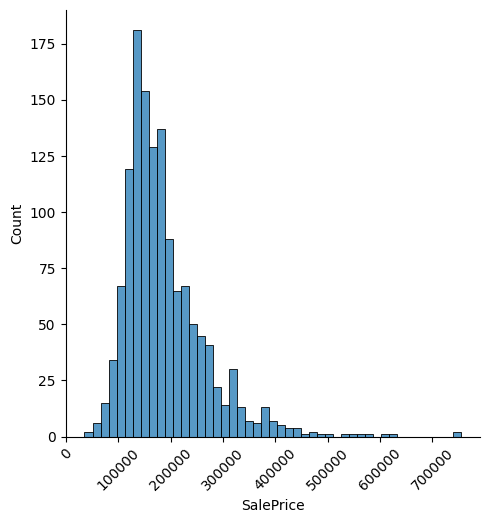

In [686]:
# target variable: price of car
sns.displot(housing_clean.SalePrice)
plt.xticks(rotation=45)
plt.show()

2. Data Exploration

In [687]:
# all numeric (float and int) variables in the dataset
housing_numeric = housing_clean.select_dtypes(include=['float64', 'int64'])
housing_numeric.head()

#some numeric data are categorical but are Ordinal. So we can still see correlation trends

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


In [688]:
housing_numeric.shape

(1338, 37)

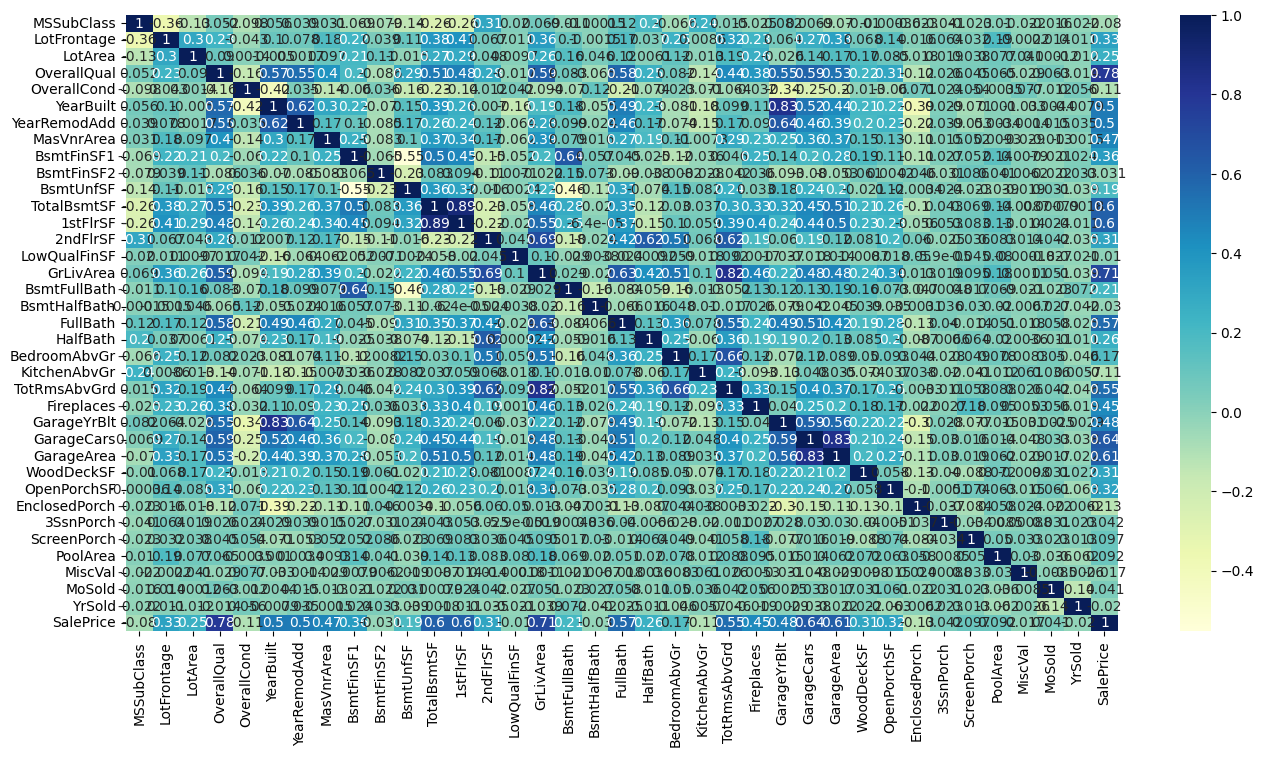

In [689]:
# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(16,8))

# heatmap
sns.heatmap(housing_numeric.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [690]:

# The matrix is too cluttred. Only keep correlations greater than 0.6 and less than -0.6
correlation_matrix = housing_numeric.corr()
high_correlation = correlation_matrix[abs(correlation_matrix) > 0.6]


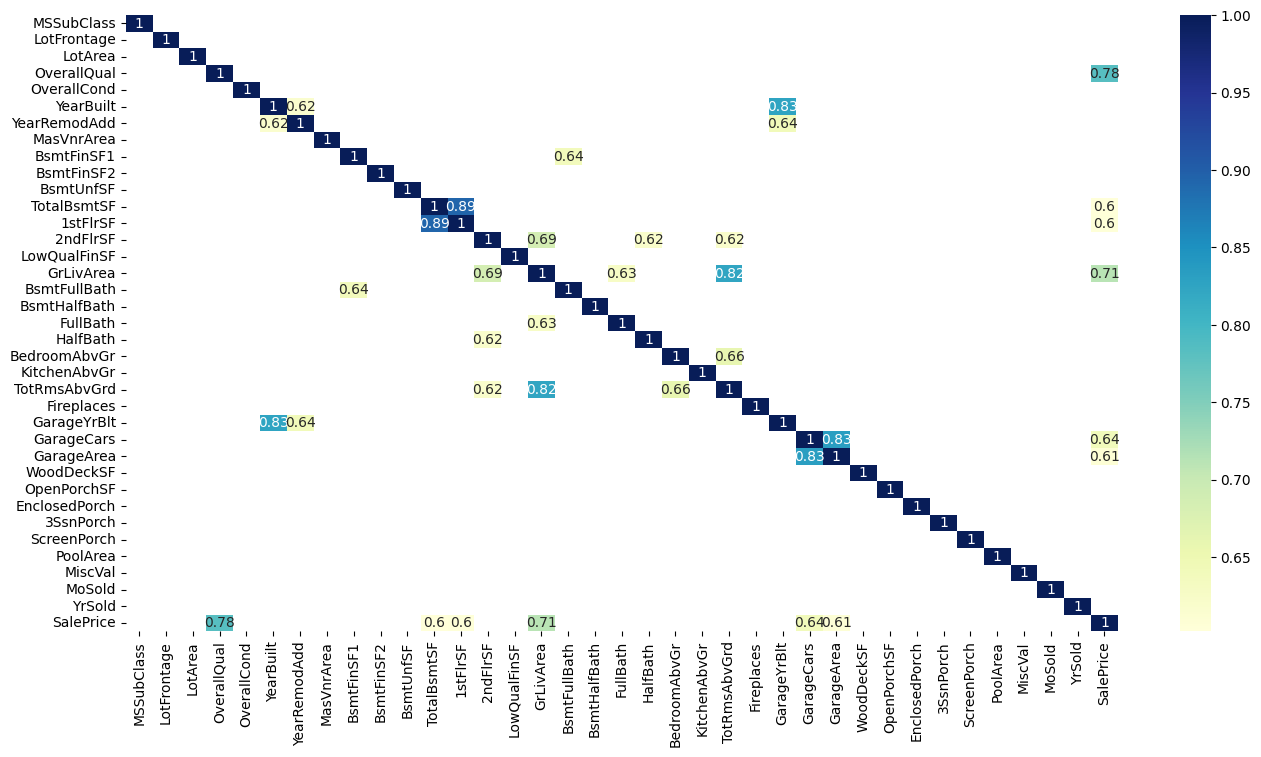

In [691]:
# plotting high correlations on a heatmap

# figure size
plt.figure(figsize=(16,8))

# heatmap
sns.heatmap(high_correlation, cmap="YlGnBu", annot=True)
plt.show()

Sale Price has a high positive correlation with:
1. OverAllQual - overall material and finish of the house
2. TotalBsmtSF
3. 1stFlrSF
4. GrLivArea - Above grade (ground) living area square feet
5. GarageCars
6. GarageArea

We also observe high correleation between the following independent varibles. These are on expected lines:
1. GarageYrBuit, YearBuilt with YearRemodAdd - which is expected. Some house owners built Garage during remodelling.
2. BsmtFullBath with BsmtFinSF1 - type 1 finished Sq Ft probably includes bath in Basement
3. 2ndFlrSf with  TotRmsAbvGrd, HalfBath, GrLivArea
4. GrLivArea with TotRmsAbvGrd, FullBath - more area would correlate to more rooms and full bath
5. BedRmsAbvGr with TotRmsAbvGr

3. Data Preparation

In [692]:
housing_clean.dtypes.value_counts()

object     37
int64      34
float64     3
Name: count, dtype: int64

In [693]:
# Get object-type columns
object_cols = housing_clean.select_dtypes(include=['object'])
object_cols

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,...,SBrkr,TA,Min1,Attchd,Unf,TA,TA,Y,WD,Normal
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,FuseA,Gd,Typ,Attchd,Unf,TA,TA,Y,WD,Normal


In [694]:
# Create dummy variables for object-type columns
dummy_cols = pd.get_dummies(object_cols, drop_first=True)  # drop_first=True to avoid dummy variable trap
dummy_cols = dummy_cols.astype(int)
dummy_cols


,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
1456,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
1457,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
1458,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0


In [695]:
# Concatenate dummy variables with the original DataFrame
housing_clean_numeric = housing_clean.drop(object_cols.columns, axis=1)
housing_with_dummies = pd.concat([housing_clean_numeric, dummy_cols], axis=1)
housing_with_dummies


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0,0,0,0,1,0,0,0,1,0
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,0,0,0,0,1,0,0,0,1,0
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0,0,0,0,1,0,0,0,1,0
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,...,0,0,0,0,1,0,0,0,1,0


In [696]:
housing_with_dummies.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,...,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,56.136024,70.438714,10706.294469,6.219731,5.596413,1973.029148,1985.668909,110.360239,464.234679,49.218236,...,0.002990,0.002990,0.087444,0.000747,0.865471,0.000747,0.005232,0.014948,0.825112,0.089686
std,41.252576,22.170305,10336.621126,1.324472,1.078124,29.563540,20.296463,185.604816,458.792420,166.196584,...,0.054615,0.054615,0.282590,0.027338,0.341348,0.027338,0.072168,0.121389,0.380013,0.285838
min,20.000000,21.000000,1300.000000,2.000000,2.000000,1880.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,60.000000,7744.000000,5.000000,5.000000,1956.000000,1968.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,50.000000,69.000000,9600.000000,6.000000,5.000000,1976.000000,1994.500000,0.000000,413.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,70.000000,80.000000,11760.750000,7.000000,6.000000,2001.000000,2004.000000,174.000000,733.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Split into test and train sets

In [697]:

np.random.seed(0)
df_train, df_test = train_test_split(housing_with_dummies, train_size = 0.7, test_size = 0.3, random_state = 100)
df_test.shape

(402, 225)

In [698]:
df_train.shape

(936, 225)

Scaling the train set - fit and tramsform

In [699]:

scaler = MinMaxScaler()

In [700]:
# select columns where it is relevant to apply scaler
cols_to_scale = housing_clean_numeric.columns
df_train[cols_to_scale] = scaler.fit_transform(df_train[cols_to_scale])
df_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1059,0.176471,0.298137,0.063253,0.500,0.714286,0.393701,0.000000,0.300000,0.131416,0.377883,...,0,0,0,0,1,0,0,0,1,0
571,0.000000,0.242236,0.038250,0.500,0.571429,0.606299,0.150000,0.129375,0.183186,0.000000,...,0,0,0,0,1,0,0,0,0,0
173,0.000000,0.366460,0.056417,0.500,0.428571,0.622047,0.183333,0.306875,0.127434,0.253731,...,0,0,0,0,0,0,0,0,1,0
732,0.235294,0.335404,0.064071,0.625,0.428571,0.913386,0.816667,0.126250,0.111504,0.000000,...,0,0,0,0,1,0,0,0,1,0
1282,0.000000,0.248447,0.047559,0.375,0.714286,0.748031,0.966667,0.000000,0.235398,0.097693,...,0,0,0,0,1,0,0,0,1,0


In [701]:
df_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,...,936.000000,936.000000,936.000000,936.000000,936.000000,936.0,936.000000,936.000000,936.000000,936.000000
mean,0.209245,0.304919,0.057860,0.525240,0.511294,0.718353,0.597952,0.068571,0.202674,0.033726,...,0.002137,0.004274,0.088675,0.001068,0.868590,0.0,0.004274,0.014957,0.831197,0.090812
std,0.243295,0.126102,0.047781,0.164172,0.152548,0.228399,0.337182,0.115990,0.192556,0.114439,...,0.046200,0.065267,0.284426,0.032686,0.338029,0.0,0.065267,0.121447,0.374778,0.287495
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.242236,0.041218,0.375000,0.428571,0.580709,0.300000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000
50%,0.176471,0.298137,0.052632,0.500000,0.428571,0.740157,0.750000,0.000000,0.178540,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000
75%,0.294118,0.366460,0.065314,0.625000,0.571429,0.937008,0.900000,0.109063,0.324004,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


Dividing train data in X and Y sets for model building

In [702]:
y_train = df_train.pop('SalePrice')
X_train = df_train

In [703]:
y_train

1059    0.256623
571     0.117674
173     0.177422
732     0.260097
1282    0.160054
          ...   
872     0.112116
56      0.190623
383     0.056537
83      0.126706
861     0.133654
Name: SalePrice, Length: 936, dtype: float64

In [704]:
X_train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1059,0.176471,0.298137,0.063253,0.500,0.714286,0.393701,0.000000,0.300000,0.131416,0.377883,...,0,0,0,0,1,0,0,0,1,0
571,0.000000,0.242236,0.038250,0.500,0.571429,0.606299,0.150000,0.129375,0.183186,0.000000,...,0,0,0,0,1,0,0,0,0,0
173,0.000000,0.366460,0.056417,0.500,0.428571,0.622047,0.183333,0.306875,0.127434,0.253731,...,0,0,0,0,0,0,0,0,1,0
732,0.235294,0.335404,0.064071,0.625,0.428571,0.913386,0.816667,0.126250,0.111504,0.000000,...,0,0,0,0,1,0,0,0,1,0
1282,0.000000,0.248447,0.047559,0.375,0.714286,0.748031,0.966667,0.000000,0.235398,0.097693,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,0.000000,0.329193,0.048142,0.375,0.714286,0.559055,0.766667,0.000000,0.000000,0.000000,...,0,0,0,0,1,0,0,0,1,0
56,0.823529,0.018634,0.008529,0.750,0.428571,0.921260,0.833333,0.285000,0.287168,0.000000,...,0,0,0,0,1,0,0,0,0,0
383,0.147059,0.242236,0.048827,0.500,0.142857,0.362205,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,1,0,0,0,1,0
83,0.000000,0.366460,0.048142,0.375,0.428571,0.614173,0.166667,0.041250,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0


4. Model Building and Evaluation

Linear Regression

In [705]:
# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(X_train, y_train)
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)

2662614450.1923494
[-2.10804119e-02  2.38781008e-02  1.07428299e-01  6.93198067e-02
  6.36051584e-02  6.92326377e-02  4.82111309e-03  3.13725554e-02
  6.86455751e+09  4.47714946e+09  7.09540104e+09 -9.40079889e+09
 -5.07966365e+09 -3.81714172e+09 -1.05733901e+09  7.75628409e+09
 -1.92537594e-03  4.22113241e-05  5.22680041e-03  8.72005651e-04
 -4.71289522e-02 -2.59258159e-02  2.84400865e-02  8.07870771e-03
 -2.44602581e-02 -3.92071377e-03  6.04746662e-02  9.30593728e-03
 -1.61875721e-03  8.50818647e-03  1.09373799e-02  5.18485334e-03
  9.04710208e-02 -3.56346369e-03 -1.58593059e-03 -5.80787659e-04
  5.99496365e-02  4.67095375e-02  5.04463911e-02  4.29229736e-02
  4.90832627e-02  4.97069955e-03  5.70322573e-03  7.01904297e-04
  1.77099705e-02 -1.46204829e-02  1.45721436e-02 -4.90490794e-02
  1.13189220e-02 -1.47895217e-02 -6.05089962e-03 -3.75986099e-03
  1.38998032e-04 -4.48146462e-02  9.66018438e-03  1.16739273e-02
  7.44426250e-03  2.90691853e-03 -4.16135788e-03  2.53982544e-02
 -1.83

Scaling to the test set  - only transform

In [706]:
df_test[cols_to_scale] = scaler.transform(df_test[cols_to_scale])

In [707]:
df_test.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,...,402.000000,402.0,402.000000,402.0,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000
mean,0.220296,0.312089,0.063808,0.532649,0.519545,0.713069,0.586401,0.069916,0.211793,0.032610,...,0.004975,0.0,0.084577,0.0,0.858209,0.002488,0.007463,0.014925,0.810945,0.087065
std,0.241307,0.161586,0.094744,0.168837,0.157428,0.242938,0.341088,0.116173,0.225595,0.108859,...,0.070447,0.0,0.278598,0.0,0.349270,0.049875,0.086171,0.121405,0.392040,0.282281
min,0.000000,0.000000,0.002410,0.000000,0.000000,-0.015748,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.242236,0.039824,0.375000,0.428571,0.582677,0.283333,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.235294,0.298137,0.052143,0.500000,0.428571,0.740157,0.733333,0.000000,0.190044,0.000000,...,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.294118,0.366460,0.068375,0.625000,0.571429,0.944882,0.895833,0.108750,0.329757,0.000000,...,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.813665,1.356658,1.000000,1.000000,1.007874,1.000000,0.705625,2.497345,0.736092,...,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [708]:
y_test = df_test.pop('SalePrice')
X_test = df_test

In [709]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print('r2 train: ',r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print('r2 test: ',r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print('rss train: ', rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print('rss test: ', rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print('mse train: ',mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print('mse test: ',mse_test_lr)
metric.append(mse_test_lr**0.5)

r2 train:  0.9314759771250362
r2 test:  -5.533468326820869e+18
rss train:  0.76746774867762
rss test:  2.684967323564483e+19
mse train:  0.0008199441759376283
mse test:  6.679023192946475e+16


Ridge Regression

In [710]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [711]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 5.0}


In [712]:
#Fitting Ridge model for alpha and printing coefficients which have been penalised
alpha = 10 #5
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[-1.93455294e-02  1.99038152e-02  1.31119326e-02  5.94755818e-02
  2.92489416e-02  1.24843794e-02  1.44511612e-02  2.76427594e-02
  4.75915646e-02  4.32858940e-03  1.10135768e-02  4.51260072e-02
  5.08081129e-02  5.64123029e-02  7.05399342e-03  6.19988046e-02
  1.10135380e-02 -2.43562060e-03  2.77563187e-02  1.12106550e-02
  4.01310674e-03 -1.33034561e-02  4.40479233e-02  2.63651454e-02
 -4.32256242e-04  2.21633532e-02  3.36456361e-02  1.82078398e-02
  5.12080168e-03  3.88958813e-03  6.60227841e-03  1.39536405e-02
  2.40755902e-02  6.45819636e-04 -3.03563554e-03 -9.20389101e-04
  7.82254849e-03  1.05507025e-03  7.29414497e-03 -1.85784837e-03
  7.64269400e-03  1.23922301e-02  4.48948753e-03 -4.17159473e-03
  1.51497382e-02 -2.24179370e-03  1.13283823e-02 -3.31223164e-03
  1.12540948e-02 -1.11299422e-02 -2.00460590e-03 -3.86068672e-03
  4.69447431e-03 -6.74436449e-03 -1.62047665e-04  2.43917711e-04
  6.13071193e-03 -9.28263073e-04 -8.84975092e-03  2.02914846e-02
 -1.92222937e-02 -1.53956

In [713]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.8999042868241444
0.7854760199428252
1.1210700776212315
1.0409201653557405
0.001197724441903025
0.0025893536451635337


Lasso

In [714]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [715]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [716]:
#Fitting Ridge model for alpha and printing coefficients which have been penalised

alpha =0.001 #0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.001)

In [717]:
lasso.coef_

array([-2.22501375e-02,  0.00000000e+00,  0.00000000e+00,  1.32628687e-01,
        0.00000000e+00,  0.00000000e+00,  1.90628084e-02,  0.00000000e+00,
        5.75148388e-02,  0.00000000e+00,  0.00000000e+00,  1.58811471e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.56087432e-01,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  1.56196969e-02,  2.15644936e-02,
        0.00000000e+00,  2.41764853e-02,  2.13729030e-02,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  1.41273525e-04, -8.36673674e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -6.59535431e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        1.35102460e-05, -0.00000000e+00, -0.00000000e+00, -2.41654959e-03,
        0.00000000e+00, -

In [718]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.847709049348277
0.7688469748999591
1.7056557414021234
1.1216081532958992
0.0018222817750022686
0.002790070033074376


In [719]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),9.314760e-01,0.899904,0.847709
1,R2 Score (Test),-5.533468e+18,0.785476,0.768847
2,RSS (Train),7.674677e-01,1.121070,1.705656
3,RSS (Test),2.684967e+19,1.040920,1.121608
4,MSE (Train),2.863467e-02,0.034608,0.042688
5,MSE (Test),2.584381e+08,0.050886,0.052821
